In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pathlib import Path
import matplotlib.pyplot as plt
datapath = Path("GNSS/")

## Background

Every satellite in space continuously broadcasts its current position coordinate information to the world through satellite signals. Any GNSS receiver can receive and read this information through an antenna.

When the satellite sends position information, it also attaches the timestamp when the data was sent. After the GNSS receiver receives the data, it subtracts the time on the timestamp from the current time, which is the time taken for the data transmission. And the approximate distance between the satellite and the GPS receiver can be calculated by data transmission time multiplied by the transmission speed, which is the `rawPrM` in `_derived` table. 

The most difficult problem in GPS positioning is error. There are many reasons for positioning errors, such as the ionosphere, the receiving device, and the blocking and multipath effects. Inorder to get a more accurate the approximate distance between the satellite and the GPS receiver with as less error as possible, we can use a corrected approximate distance as [home page](https://www.kaggle.com/c/google-smartphone-decimeter-challenge/data) suggested, which can be computed as: `correctedPrM = rawPrM + satClkBiasM - isrbM - ionoDelayM - tropoDelayM`

<img src='https://www.researchgate.net/publication/324989880/figure/fig1/AS:623672356253699@1525706485241/Global-Navigation-Satellite-System-GNSS-spoofing-attack-illustration.png' width=400/>

Normally these values are need to be calculated carefully from GNSSLog file by lots of domain knowledge. Thanks to the dataset provider, we can directly use the intermediate calculated value from derived files to built the initial version of the model.

### Basic Utils Functions

In [41]:
def ecef2lla(x, y, z):
  # x, y and z are scalars or vectors in meters
  x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
  y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
  z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

  a=6378137
  a_sq=a**2
  e = 8.181919084261345e-2
  e_sq = 6.69437999014e-3

  f = 1/298.257223563
  b = a*(1-f)

  # calculations:
  r = np.sqrt(x**2 + y**2)
  ep_sq  = (a**2-b**2)/b**2
  ee = (a**2-b**2)
  f = (54*b**2)*(z**2)
  g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
  c = (e_sq**2)*f*r**2/(g**3)
  s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
  p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
  q = np.sqrt(1 + 2*p*e_sq**2)
  r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
  u = np.sqrt((r - e_sq*r_0)**2 + z**2)
  v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
  z_0 = (b**2)*z/(a*v)
  h = u*(1 - b**2/(a*v))
  phi = np.arctan((z + ep_sq*z_0)/r)
  lambd = np.arctan2(y, x)

  return phi*180/np.pi, lambd*180/np.pi, h

### Load Data

In [42]:
df_baseline = pd.read_csv(datapath/"baseline_locations_train.csv")
df_sample_trail_gt = pd.read_csv(datapath/"train/2020-05-14-US-MTV-1/Pixel4/ground_truth.csv")
df_sample_trail = pd.read_csv(datapath/"train/2020-05-14-US-MTV-1/Pixel4/Pixel4_derived.csv")
#df_baseline = pd.read_csv("baseline_locations_train.csv")
#df_sample_trail_gt = pd.read_csv("ground_truth.csv")
#df_sample_trail = pd.read_csv("Pixel4_derived.csv")
df_sample_trail["correctedPrM"] = df_sample_trail["rawPrM"] + df_sample_trail["satClkBiasM"] - df_sample_trail["isrbM"] - df_sample_trail["ionoDelayM"] - df_sample_trail["tropoDelayM"] 

## Simple Least Square Solution

An intuitive solution to solve this problem is utilizing the basic geometry information to infer the GNSS receiver location. Since we have multiple satellite, we can optimize the location to achieve the minimum projection error among all satellite based by least square.

To be more specific,

$r_u^k = ||x^k_{sat} - x_u||$

where,

$r_u^k$: the actually distance between user device (GNSS Receiver) to Satellite;

$x^k_{sat}$: the actually position of Satellite;

$x_u$: the actually position of user device (GNSS Receiver).

$ Pr_u^k = r_u^k + b_u + \sigma^k $

where,

$Pr_u^k$: the corrected pseudorange (i.e. a closer approximation to the geometric range from the phone to the satellite) can be computed as: $correctedPrM = rawPrM + satClkBiasM - isrbM - ionoDelayM - tropoDelayM;$

$b_u$: the user clock bias in meters equivalent, which $b_u = clock\_bias_u * LIGHTSPEED;$

$\sigma^k$: the actually position of user device (GNSS Receiver).

Our aim is to minimize the measured and the estimated pseudorange for each satellite:

$$\delta Pr_u^k = Pr_u^k - (r_u^k + b_u) = Pr_u^k - (||x^k_{sat} - x_u|| + b_u)$$

which is our target function in least square solver.

 Which can be deducted to based equation (5) in [here](https://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data/):

$$\delta Pr_u^k = - \frac{x^k_{sat} - x_u}{||x^k_{sat} - x_u||} \delta x_u^k + \delta b_u + \sigma^k = - \hat{x}_u^k \delta x_u^k + \delta b_u + \sigma^k$$ --

Let's try it with 1 single epoch.

In [43]:
epoch_time = 1273529464442
df_sample_epoch = df_sample_trail[df_sample_trail.millisSinceGpsEpoch == epoch_time]
df_sample_epoch_gt = df_sample_trail_gt[df_sample_trail_gt.millisSinceGpsEpoch == epoch_time]
df_sample_epoch_baseline = df_baseline[(df_baseline.collectionName == "2020-05-14-US-MTV-1") & (df_baseline.phoneName == "Pixel4") & (df_baseline.millisSinceGpsEpoch == epoch_time)]

sat_pos = df_sample_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
pseudoranges = np.squeeze(df_sample_epoch[["correctedPrM"]].to_numpy())

### self implement simple least square

Build the simplest version from [code](https://www.kaggle.com/realbigmitchell/simple-least-squares-solution) and [article](https://www.telesens.co/2017/07/17/calculating-position-from-raw-gps-data/).

In [44]:
def least_squares(sat_pos, pseudoranges, weights=1, x_hat=np.array([0, 0, 0, 0])):
  """
  Args:
    sat_pos: The satellite position (meters) in an ECEF coordinate frame
    pseudoranges: The corrected pseudorange (i.e. a closer approximation to the geometric range from the phone to the satellite)
    x_hat: the phone's initial/previous estimated position (x, y, z, b) and 
           b represent the user clock bias in units of distance = clock bias (t) * light speed (c)
  
  Returns:
    x_hat: the phone's estimated position
    norm_dp:
  """
  dx = np.Inf*np.ones(3)
  G = np.ones((pseudoranges.size, 4))
  iterations = 0

  if isinstance(weights, np.ndarray):
    weights = np.diag(weights)
  else:
    weights = weights*np.eye(pseudoranges.size)

  while np.linalg.norm(dx) > 1e-3:
    norms = np.linalg.norm(sat_pos - x_hat[:3], axis=1)
    dp = pseudoranges - norms - x_hat[3]
    G[:, 0:3] = -(sat_pos - x_hat[:3])/norms[:, None]
    # G_T = np.transpose(G)
    # dx = np.linalg.inv(G_T@G) @ G_T @ dp
    dx = np.linalg.pinv(weights@G) @ weights @ dp
    x_hat = x_hat + dx
    iterations += 1
  return x_hat, np.linalg.norm(dp)

In [45]:
x, dp = least_squares(sat_pos, pseudoranges)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Simple Least Square Estimation:", *ecef2lla(*x[:3]))
# print(b/LIGHTSPEED)
# print(dp)

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Simple Least Square Estimation: [[37.42361372]] [[-122.0936959]] [[-26.18615617]]


### scipy optimize version

Build the simplest version from [this code](https://github.com/commaai/laika/blob/master/laika/raw_gnss.py#L254-L350)

In [46]:
import scipy.optimize as opt

def calc_pos_fix(sat_pos, pr, weights=1, x0=[0, 0, 0, 0]):
  '''
  Calculates gps fix with WLS optimizer
  returns:
  0 -> list with positions
  1 -> pseudorange errs
  '''
  n = len(pr)
  if n < 3:
      return x0, []

  Fx_pos = pr_residual(sat_pos, pr, weights=weights)
  opt_pos = opt.least_squares(Fx_pos, x0).x
  return opt_pos, Fx_pos(opt_pos, weights=1)


def pr_residual(sat_pos, pr, weights=1):
  # solve for pos
  def Fx_pos(x_hat, weights=weights):
    rows = weights * (np.linalg.norm(sat_pos - x_hat[:3], axis=1) + x_hat[3] - pr)
    return rows
  return Fx_pos

In [47]:
x, dp = calc_pos_fix(sat_pos, pseudoranges)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Simple Least Square Estimation:", *ecef2lla(*x[:3]))
# print(x[3]/LIGHTSPEED)
# print(dp)

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Simple Least Square Estimation: [[37.42361372]] [[-122.0936959]] [[-26.18615456]]


## Weighted Least Square Solution

The signal from each satellite may not that reliable. In this case, we can apply the reliability of the signal as weights for each signal to improve the least square result. Here, we use the `rawPrUncM` as the weights for signal, which represents the pseudorange uncertainty/deviation of each signal. The relative code can be found at [the google official repo](WLS shown in official repo](https://github.com/google/gps-measurement-tools/blob/master/opensource/WlsPvt.m#L62-L111)

In [48]:
pseudoranges_sigma = np.squeeze(df_sample_epoch[["rawPrUncM"]].to_numpy())

x, dp = least_squares(sat_pos, pseudoranges, 1/pseudoranges_sigma)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation:", *ecef2lla(*x[:3]))

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Weighted Least Square Estimation: [[37.42357917]] [[-122.09375829]] [[-35.25074978]]


In [49]:
pseudoranges_sigma = np.squeeze(df_sample_epoch[["rawPrUncM"]].to_numpy())

x, dp = calc_pos_fix(sat_pos, pseudoranges, 1/pseudoranges_sigma)

print("Ground truth:", df_sample_epoch_gt[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation (Baseline):", df_sample_epoch_baseline[["latDeg","lngDeg","heightAboveWgs84EllipsoidM"]].to_numpy())
print("Weighted Least Square Estimation:", *ecef2lla(*x[:3]))

Ground truth: [[  37.42357595 -122.09413204   33.21      ]]
Weighted Least Square Estimation (Baseline): [[  37.4235777 -122.094101   -33.29     ]]
Weighted Least Square Estimation: [[37.42357917]] [[-122.09375829]] [[-35.25074951]]


## Evaluation

In [50]:
def calc_haversine(lat1, lon1, lat2, lon2):
  """Calculates the great circle distance between two points
  on the earth. Inputs are array-like and specified in decimal degrees.
  """
  RADIUS = 6_367_000
  lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
  dlat = lat2 - lat1
  dlon = lon2 - lon1
  a = np.sin(dlat/2)**2 + \
      np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  dist = 2 * RADIUS * np.arcsin(a**0.5)
  return dist

### Evaluate in one epoch

In [51]:
deg_gt = df_sample_epoch_gt[["latDeg","lngDeg"]].to_numpy().transpose()
deg_baseline = df_sample_epoch_baseline[["latDeg","lngDeg"]].to_numpy().transpose()
print("Weighted Least Square (baseline) haversine distance (M):", calc_haversine(*deg_gt, *deg_baseline))
print("Weighted Least Square haversine distance (M):", calc_haversine(*deg_gt, *ecef2lla(*x[:3])[:2]))

Weighted Least Square (baseline) haversine distance (M): [2.74590055]
Weighted Least Square haversine distance (M): [[32.98570784]]


### Evaluate in whole training

In [52]:
def simple_pipeline(df_trails):
  """ simple pipeline to estimate the GNSS receiver location by least square
  Args:
    df_trails: the df read from derived file
  
  Returns:
    result df with estimated degrees and heights
  """
  df_trails["correctedPrM"] = df_trails["rawPrM"] + df_trails["satClkBiasM"] - df_trails["isrbM"] - df_trails["ionoDelayM"] - df_trails["tropoDelayM"]
  
  results = []
  x = [0, 0, 0, 0]
  df_epochs = df_trails.groupby(["collectionName", "phoneName", "millisSinceGpsEpoch"])
  for indices, df_epoch in tqdm(df_epochs, desc="Estimate location by LS for epoch"):
    sat_pos = df_epoch[["xSatPosM","ySatPosM","zSatPosM"]].to_numpy()
    pseudoranges = np.squeeze(df_epoch[["correctedPrM"]].to_numpy())
    pseudoranges_sigma = np.squeeze(df_epoch[["rawPrUncM"]].to_numpy())
    x, _ = calc_pos_fix(sat_pos, pseudoranges, 1/pseudoranges_sigma, x)
    # x, _ = calc_pos_fix(sat_pos, pseudoranges, 1, x)
    values = np.squeeze(ecef2lla(*x[:3]))
    results.append([*indices, *values])
  return pd.DataFrame(results,columns=["collectionName", "phoneName", "millisSinceGpsEpoch", "latDeg", "lngDeg", "heightAboveWgs84EllipsoidM"])

In [54]:
from pathlib import Path
# from tqdm import tqdm
from tqdm.notebook import tqdm

# datapath = Path("./data")
ground_truths = (datapath / "train").rglob("ground_truth.csv")
drived_files = (datapath / "train").rglob("*_derived.csv")
#ground_truths = ("ground_truth.csv")
#drived_files = ("Pixel4_derived.csv")

#df_sample_trails_baseline = pd.read_csv(datapath / 'baseline_locations_train.csv')
df_sample_trails_baseline = pd.read_csv('baseline_locations_train.csv')
df_sample_trails_gt = pd.concat([pd.read_csv("ground_truth.csv") for filepath in tqdm(ground_truths, total=73, desc="Reading ground truth data")], ignore_index=True)
df_sample_trails = pd.concat([pd.read_csv("Pixel4_derived.csv") for filepath in tqdm(drived_files, total=73, desc="Reading drived data")], ignore_index=True)
df_sample_trails_baseline.to_csv('df_sample_trails_baseline.csv', sep=',', index=False, encoding='utf-8')
df_sample_trails_gt.to_csv('df_sample_trails_gt.csv', sep=',', index=False, encoding='utf-8')
df_sample_trails.to_csv('df_sample_trails.csv', sep=',', index=False, encoding='utf-8')

Reading ground truth data:   0%|          | 0/73 [00:00<?, ?it/s]

Reading drived data:   0%|          | 0/73 [00:00<?, ?it/s]

In [15]:
df_sample_trails_gt["receivedSvTimeInGpsNanos"] = df_sample_trails_gt.millisSinceGpsEpoch*int(1e6)
df_sample_trails_raw = df_sample_trails.drop("millisSinceGpsEpoch", axis=1)

df_merge = pd.merge_asof(df_sample_trails_raw.sort_values('receivedSvTimeInGpsNanos'), df_sample_trails_gt.sort_values('receivedSvTimeInGpsNanos'), 
                                           on="receivedSvTimeInGpsNanos", by=["collectionName", "phoneName"], direction='nearest',tolerance=int(1e9))
df_merge = df_merge.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

In [16]:
df_sample_trails_estimate = simple_pipeline(df_merge)

Estimate location by LS for epoch:   0%|          | 0/1739 [00:00<?, ?it/s]

In [17]:
df_sample_trails_estimate

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423579,-122.093758,-35.250749
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.093768,-33.858938
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423575,-122.093780,-31.906072
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423578,-122.093787,-31.646298
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423575,-122.093784,-33.484348
...,...,...,...,...,...,...
1734,2020-05-14-US-MTV-1,Pixel4,1273531197442,37.645809,-122.405262,-28.689893
1735,2020-05-14-US-MTV-1,Pixel4,1273531198442,37.645816,-122.405279,-30.292399
1736,2020-05-14-US-MTV-1,Pixel4,1273531199442,37.645813,-122.405271,-29.616842
1737,2020-05-14-US-MTV-1,Pixel4,1273531200442,37.645807,-122.405258,-30.460821


In [18]:
df_sample_trails_baseline

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4
...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra


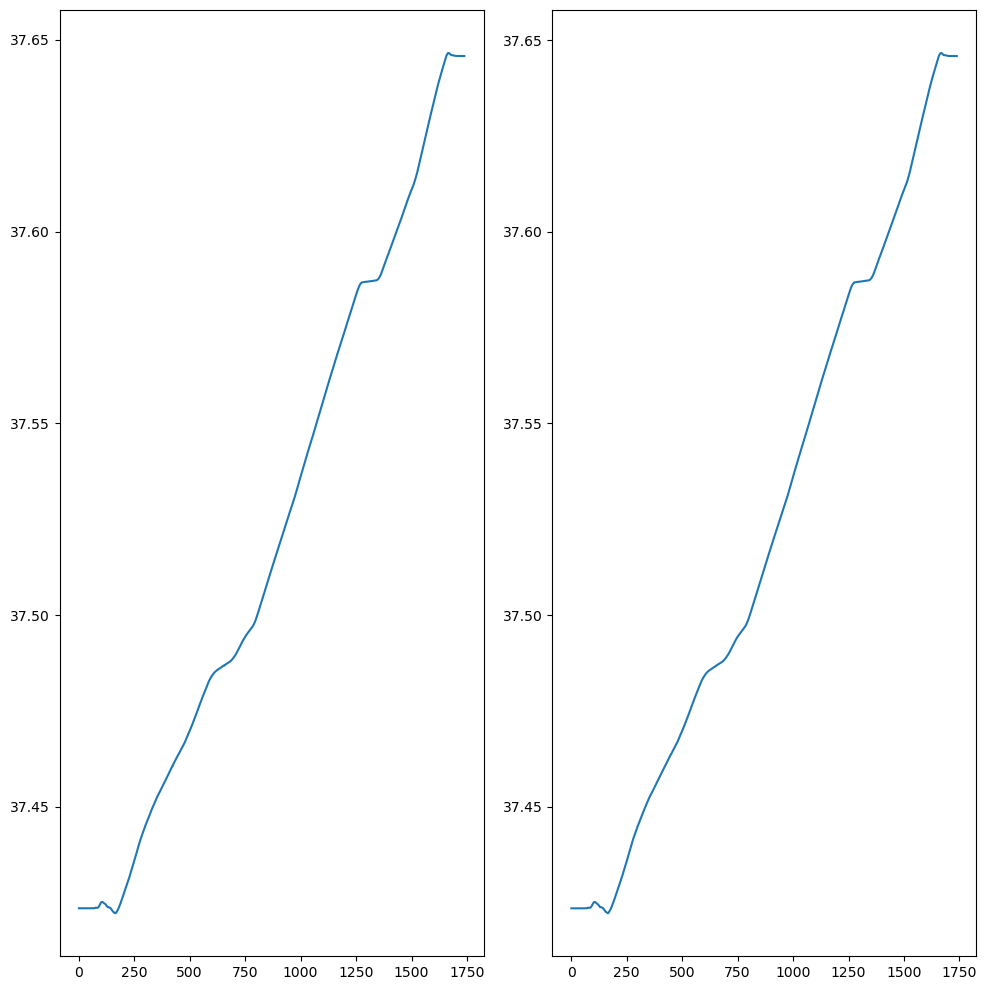

In [19]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(df_sample_trails_estimate.latDeg)
plt.subplot(1, 2, 2)
plt.plot(df_sample_trails_baseline.latDeg.iloc[:1739])
plt.tight_layout()
plt.show()


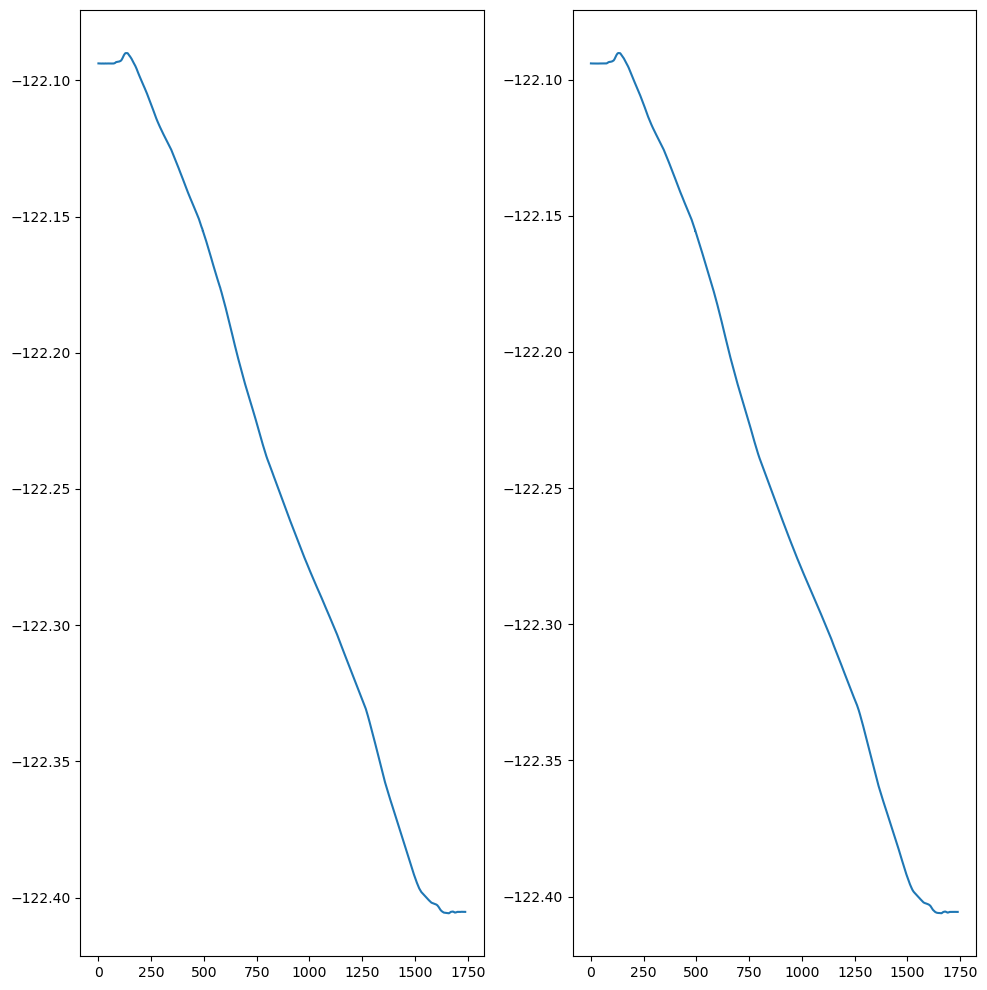

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(df_sample_trails_estimate.lngDeg)
plt.subplot(1, 2, 2)
plt.plot(df_sample_trails_baseline.lngDeg.iloc[:1739])
plt.tight_layout()
plt.show()

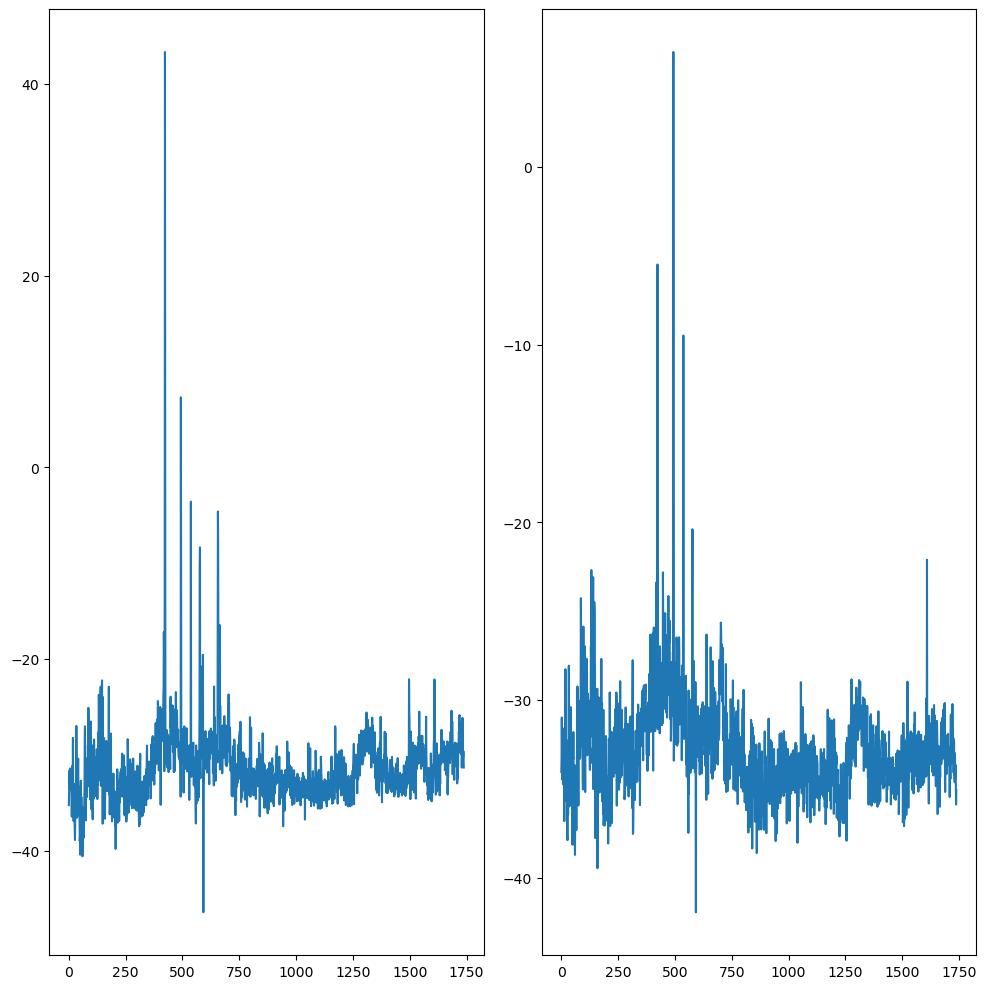

In [21]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(df_sample_trails_estimate.heightAboveWgs84EllipsoidM)
plt.subplot(1, 2, 2)
plt.plot(df_sample_trails_baseline.heightAboveWgs84EllipsoidM.iloc[:1739])
plt.tight_layout()
plt.show()


In [22]:
difference_lat = df_sample_trails_estimate.latDeg - df_sample_trails_baseline.latDeg.iloc[:1739]
difference_lng = df_sample_trails_estimate.lngDeg - df_sample_trails_baseline.lngDeg.iloc[:1739]
difference_H = df_sample_trails_estimate.heightAboveWgs84EllipsoidM - df_sample_trails_baseline.heightAboveWgs84EllipsoidM.iloc[:1739]

In [23]:
difference_lat, difference_lng, difference_H

(0       3.874465e-06
 1       3.117127e-07
 2       2.193565e-06
 3      -4.967393e-06
 4      -3.879517e-06
             ...     
 1734   -6.107725e-06
 1735    2.321874e-06
 1736   -5.464511e-06
 1737   -6.171615e-06
 1738    2.976361e-06
 Name: latDeg, Length: 1739, dtype: float64,
 0       0.000333
 1       0.000333
 2       0.000331
 3       0.000335
 4       0.000330
           ...   
 1734    0.000343
 1735    0.000336
 1736    0.000345
 1737    0.000341
 1738    0.000333
 Name: lngDeg, Length: 1739, dtype: float64,
 0      -1.190749
 1      -0.568938
 2      -0.916072
 3       1.183702
 4       1.005652
           ...   
 1734    5.660107
 1735    3.367601
 1736    5.153158
 1737    5.429179
 1738    3.743298
 Name: heightAboveWgs84EllipsoidM, Length: 1739, dtype: float64)

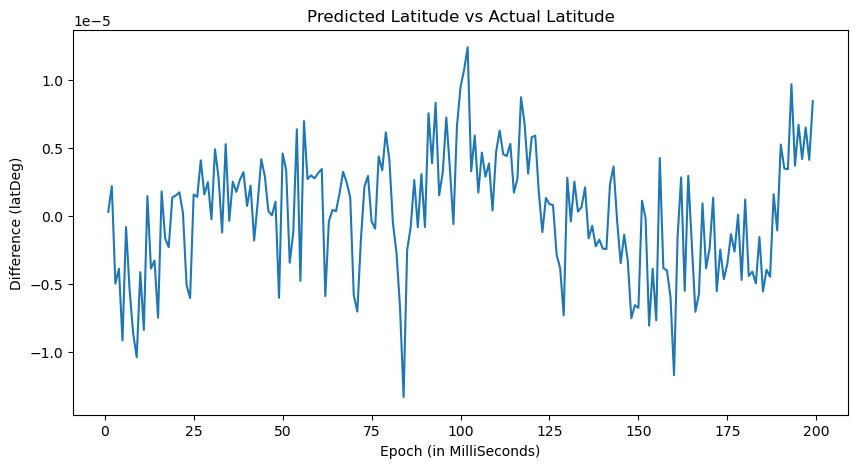

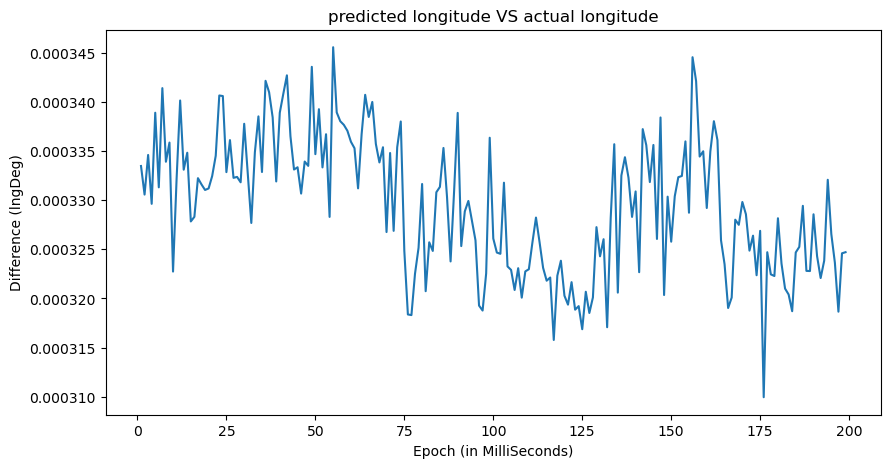

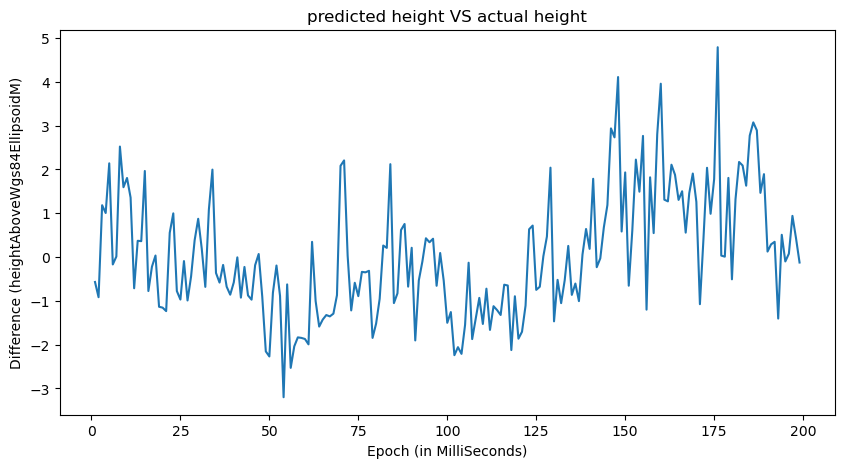

In [39]:
selected_rowslat = difference_lat[1:200] 
plt.figure(figsize=(10, 5))
plt.plot(selected_rowslat)
plt.xlabel('Epoch (in MilliSeconds)')
plt.ylabel('Difference (latDeg)')
plt.title('Predicted Latitude vs Actual Latitude')
plt.show()

selected_rowslng = difference_lng[1:200] 
plt.figure(figsize=(10, 5))
plt.plot(selected_rowslng)
plt.xlabel('Epoch (in MilliSeconds)')
plt.ylabel('Difference (lngDeg)')
plt.title('predicted longitude VS actual longitude')
plt.show()

selected_rowsH = difference_H[1:200] 
plt.figure(figsize=(10, 5))
plt.plot(selected_rowsH)
plt.xlabel('Epoch (in MilliSeconds)')
plt.ylabel('Difference (heightAboveWgs84EllipsoidM)')
plt.title('predicted height VS actual height')
plt.show()

In [27]:
df_sample_trails_merged_baseline = pd.merge_asof(df_sample_trails_gt.sort_values('millisSinceGpsEpoch'),
                                                 df_sample_trails_baseline.sort_values('millisSinceGpsEpoch'), 
                                                 on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                                                 direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
df_sample_trails_merged_baseline = df_sample_trails_merged_baseline.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

df_sample_trails_merged_SL = pd.merge_asof(df_sample_trails_gt.sort_values('millisSinceGpsEpoch'), 
                                           df_sample_trails_estimate.sort_values('millisSinceGpsEpoch'), 
                                           on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], 
                                           direction='nearest',tolerance=100000, suffixes=('_truth', '_pred'))
df_sample_trails_merged_SL = df_sample_trails_merged_SL.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

compared_cols = ["latDeg_truth","lngDeg_truth","latDeg_pred","lngDeg_pred"]
print("Weighted Least Square (baseline) haversine distance (M):", calc_haversine(*df_sample_trails_merged_baseline[compared_cols].to_numpy().transpose()).mean())
print("Weighted Least Square haversine distance (M):", calc_haversine(*df_sample_trails_merged_SL[compared_cols].to_numpy().transpose()).mean())

Weighted Least Square (baseline) haversine distance (M): 1.4564586662027648
Weighted Least Square haversine distance (M): 28.95097805539799


In [28]:
# Select relevant features and target variable
X = df_merge[['xSatPosM', 'ySatPosM', 'zSatPosM', 'correctedPrM', 'rawPrUncM']].values
y = df_merge[['latDeg', 'lngDeg']].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
# Assuming X and y are your features and target variable
X_train, _, y_train, _ = train_test_split(X, y, train_size=0.1, random_state=42)

# Train the model with the reduced dataset
model.fit(X_train, y_train)
# Define Gaussian Process Kernel (you can adjust hyperparameters)
kernel = RBF(length_scale=1.0)
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)

# Train the model
model.fit(X_train, y_train)


NameError: name 'model' is not defined

In [ ]:
# Make predictions on the test set
y_pred, sigma = model.predict(X_test, return_std=True)


In [ ]:
# Evaluate the model performance (you can use other metrics as needed)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


In [ ]:
# Assuming you have a new set of data for which you want to estimate positions
new_data = pd.DataFrame(...)  # Replace ... with your new data
X_new = new_data[['xSatPosM', 'ySatPosM', 'zSatPosM', 'correctedPrM', 'rawPrUncM']].values

# Predict positions for new data
new_positions = model.predict(X_new)


## Submission

It should be noticed that the epoch time in the drived file and submission/baseline file is not same, in this case, we need to merge it to submission format with epoch time tolerant and sort it into suitable output format (based on quick experiment, 100s tolerant can be merged without empty value).

In [18]:
from pathlib import Path
# from tqdm import tqdm
from tqdm.notebook import tqdm

# datapath = Path("./data")
drived_files = (datapath / "test").rglob("*_derived.csv")

df_sample_trails_baseline = pd.read_csv(datapath / 'baseline_locations_test.csv')
df_sample_trails = pd.concat([pd.read_csv(filepath) for filepath in tqdm(drived_files, total=48, desc="Reading drived data")], ignore_index=True)

Reading drived data:   0%|          | 0/48 [00:00<?, ?it/s]

In [19]:
df_sample_trails_baseline["receivedSvTimeInGpsNanos"] = df_sample_trails_baseline.millisSinceGpsEpoch*int(1e6)
df_sample_trails_raw = df_sample_trails.drop("millisSinceGpsEpoch", axis=1)

df_merge = pd.merge_asof(df_sample_trails_raw.sort_values('receivedSvTimeInGpsNanos'), df_sample_trails_baseline.sort_values('receivedSvTimeInGpsNanos'), 
                                           on="receivedSvTimeInGpsNanos", by=["collectionName", "phoneName"], direction='nearest',tolerance=int(1e9))
df_merge = df_merge.sort_values(by=["collectionName", "phoneName", "millisSinceGpsEpoch"], ignore_index=True)

In [20]:
df_sample_trails_estimate = simple_pipeline(df_merge)

Estimate location by LS for epoch:   0%|          | 0/90886 [00:00<?, ?it/s]

In [21]:
df_sample_trails_baseline = df_sample_trails_baseline.drop(["latDeg","lngDeg","heightAboveWgs84EllipsoidM"], axis=1)
df_sample_trails_merged = pd.merge_asof(df_sample_trails_baseline.sort_values('millisSinceGpsEpoch'), 
                                        df_sample_trails_estimate.sort_values('millisSinceGpsEpoch'), 
                                        on="millisSinceGpsEpoch", by=["collectionName", "phoneName"], direction='nearest', tolerance=100000)
df_sample_trails_merged = df_sample_trails_merged.sort_values(by=["phone", "millisSinceGpsEpoch"], ignore_index=True)

df_submission = df_sample_trails_merged[["phone", "millisSinceGpsEpoch", "latDeg", "lngDeg"]].copy()
df_submission.to_csv('submission.csv', index=False)

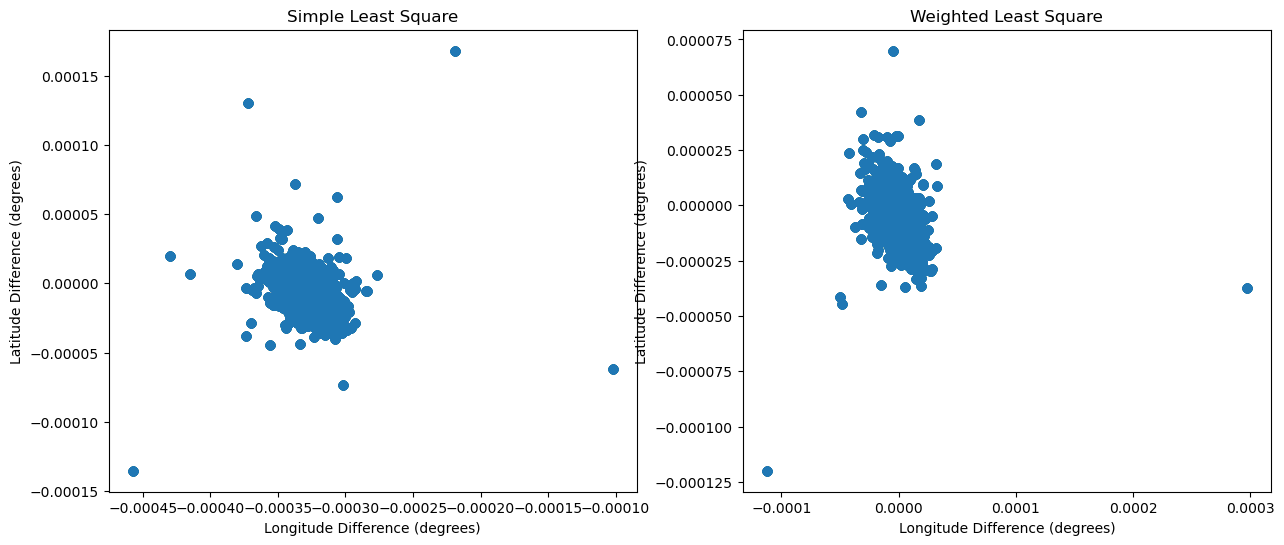

In [22]:
import matplotlib.pyplot as plt

# Calculate differences for SL and Weighted LS
df_sample_trails_merged_SL["latDiff"] = df_sample_trails_merged_SL["latDeg_truth"] - df_sample_trails_merged_SL["latDeg_pred"]
df_sample_trails_merged_SL["lngDiff"] = df_sample_trails_merged_SL["lngDeg_truth"] - df_sample_trails_merged_SL["lngDeg_pred"]

df_sample_trails_merged_baseline["latDiff"] = df_sample_trails_merged_baseline["latDeg_truth"] - df_sample_trails_merged_baseline["latDeg_pred"]
df_sample_trails_merged_baseline["lngDiff"] = df_sample_trails_merged_baseline["lngDeg_truth"] - df_sample_trails_merged_baseline["lngDeg_pred"]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot for SL
axes[0].scatter(df_sample_trails_merged_SL["lngDiff"], df_sample_trails_merged_SL["latDiff"], alpha=0.5)
axes[0].set_title('Simple Least Square')

# Scatter plot for Weighted LS
axes[1].scatter(df_sample_trails_merged_baseline["lngDiff"], df_sample_trails_merged_baseline["latDiff"], alpha=0.5)
axes[1].set_title('Weighted Least Square')

# Set common labels
for ax in axes:
    ax.set_xlabel('Longitude Difference (degrees)')
    ax.set_ylabel('Latitude Difference (degrees)')

plt.show()


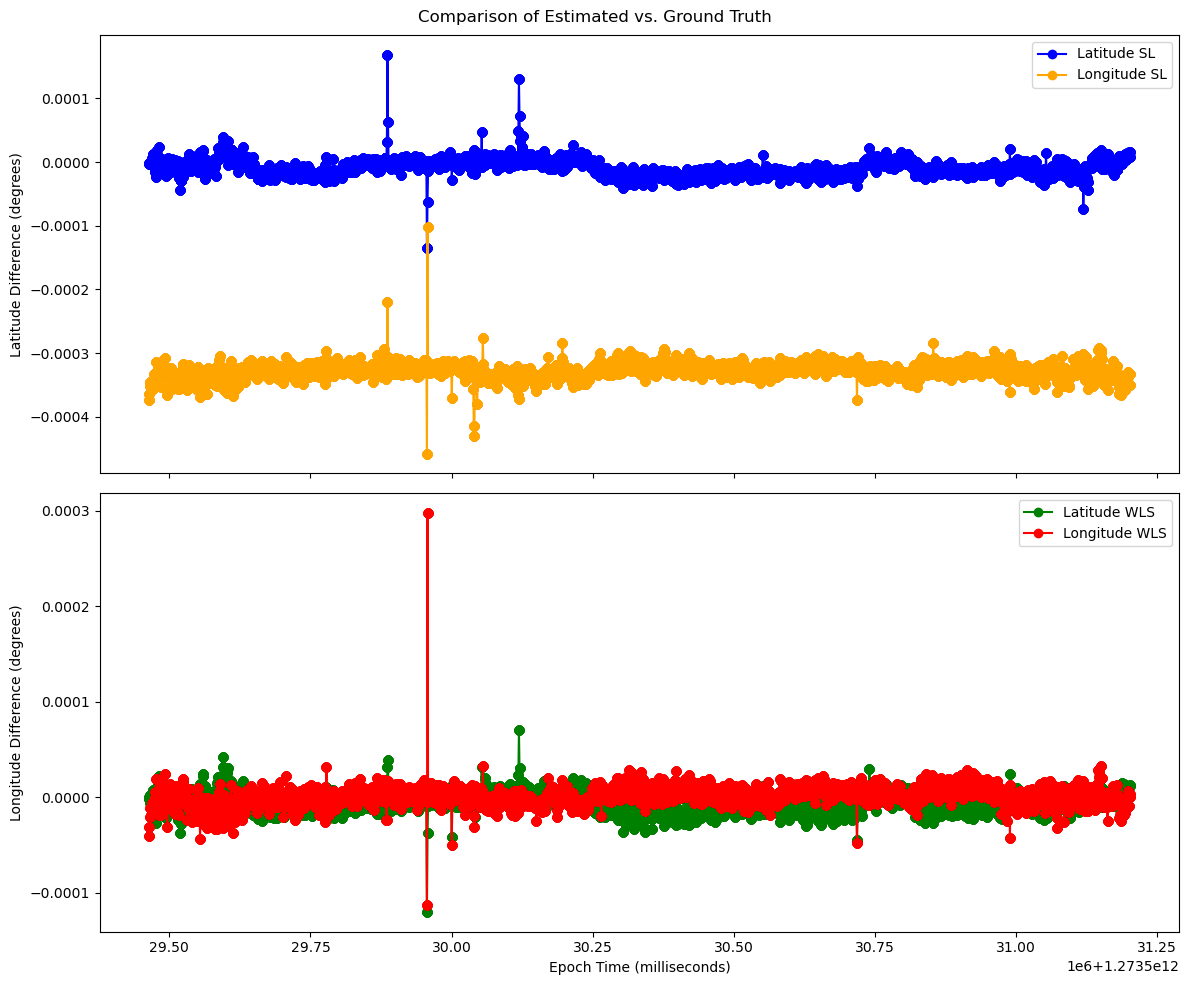

In [23]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Line plot for Simple Least Square
axes[0].plot(df_sample_trails_merged_SL["millisSinceGpsEpoch"], df_sample_trails_merged_SL["latDeg_truth"] - df_sample_trails_merged_SL["latDeg_pred"], label='Latitude SL', marker='o', linestyle='-', color='blue')
axes[0].plot(df_sample_trails_merged_SL["millisSinceGpsEpoch"], df_sample_trails_merged_SL["lngDeg_truth"] - df_sample_trails_merged_SL["lngDeg_pred"], label='Longitude SL', marker='o', linestyle='-', color='orange')

# Line plot for Weighted Least Square
axes[1].plot(df_sample_trails_merged_baseline["millisSinceGpsEpoch"], df_sample_trails_merged_baseline["latDeg_truth"] - df_sample_trails_merged_baseline["latDeg_pred"], label='Latitude WLS', marker='o', linestyle='-', color='green')
axes[1].plot(df_sample_trails_merged_baseline["millisSinceGpsEpoch"], df_sample_trails_merged_baseline["lngDeg_truth"] - df_sample_trails_merged_baseline["lngDeg_pred"], label='Longitude WLS', marker='o', linestyle='-', color='red')

# Set common title
fig.suptitle('Comparison of Estimated vs. Ground Truth')

# Set common xlabel
plt.xlabel('Epoch Time (milliseconds)')

# Set y-axis labels
axes[0].set_ylabel('Latitude Difference (degrees)')
axes[1].set_ylabel('Longitude Difference (degrees)')

# Add legend
axes[0].legend()
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


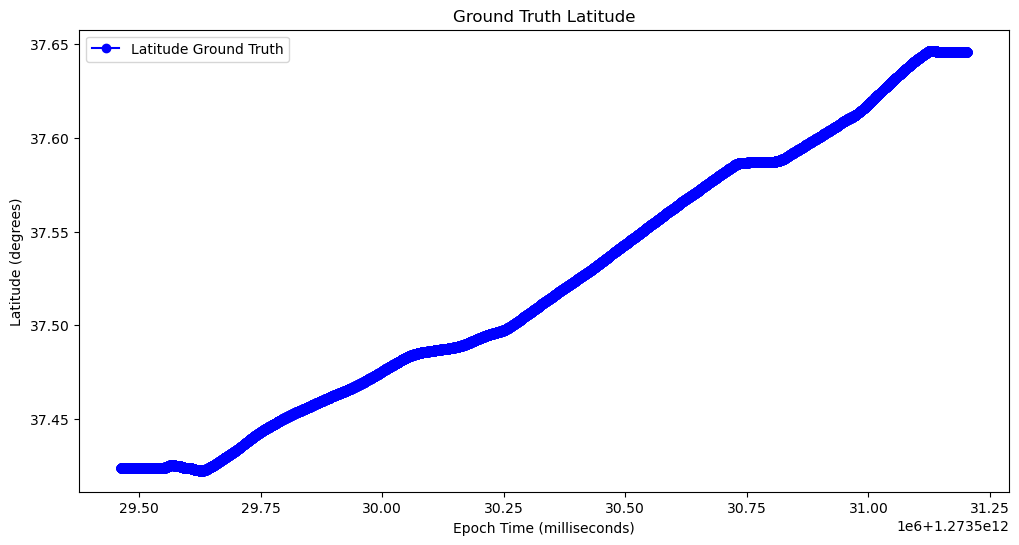

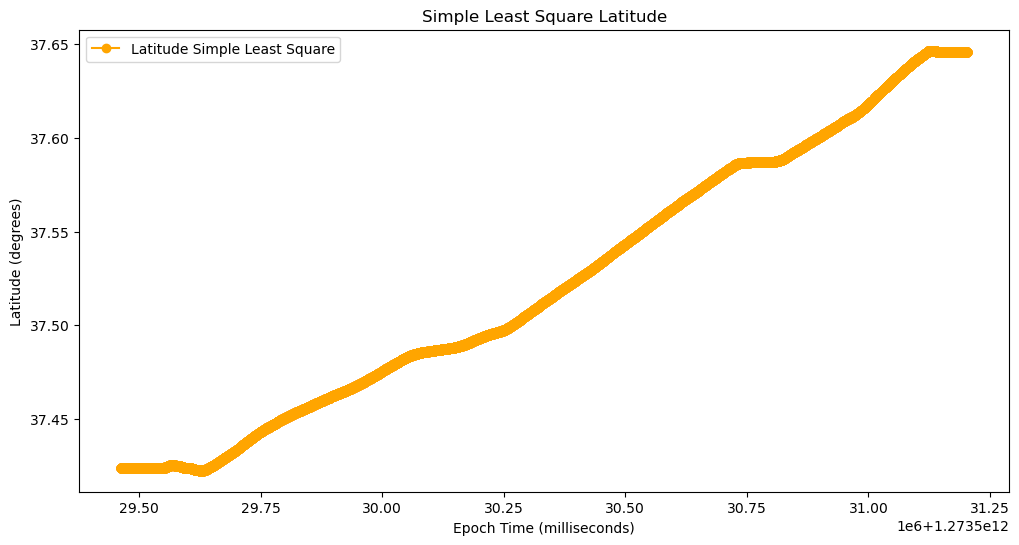

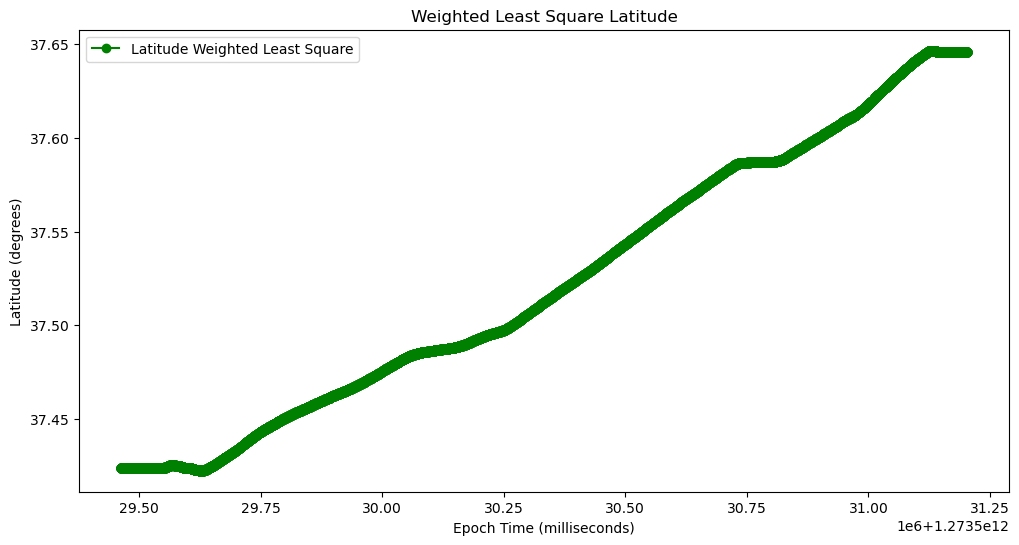

In [24]:
import matplotlib.pyplot as plt

# Ground Truth - Latitude
plt.figure(figsize=(12, 6))
plt.plot(df_sample_trails_merged_SL["millisSinceGpsEpoch"], df_sample_trails_merged_SL["latDeg_truth"], label='Latitude Ground Truth', marker='o', linestyle='-', color='blue')
plt.title('Ground Truth Latitude')
plt.xlabel('Epoch Time (milliseconds)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.show()

# Simple Least Square - Latitude
plt.figure(figsize=(12, 6))
plt.plot(df_sample_trails_merged_SL["millisSinceGpsEpoch"], df_sample_trails_merged_SL["latDeg_pred"], label='Latitude Simple Least Square', marker='o', linestyle='-', color='orange')
plt.title('Simple Least Square Latitude')
plt.xlabel('Epoch Time (milliseconds)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.show()

# Weighted Least Square - Latitude
plt.figure(figsize=(12, 6))
plt.plot(df_sample_trails_merged_baseline["millisSinceGpsEpoch"], df_sample_trails_merged_baseline["latDeg_pred"], label='Latitude Weighted Least Square', marker='o', linestyle='-', color='green')
plt.title('Weighted Least Square Latitude')
plt.xlabel('Epoch Time (milliseconds)')
plt.ylabel('Latitude (degrees)')
plt.legend()
plt.show()


In [25]:
import numpy as np

def create_state(df_epoch):
    # Extract relevant features from the DataFrame
    features = [
        "xSatPosM", "ySatPosM", "zSatPosM",   # Satellite positions
        "rawPrM", "satClkBiasM", "isrbM",      # GNSS measurements
        "ionoDelayM", "tropoDelayM",           # Atmospheric delays
        # Add any additional features relevant to your problem
    ]

    # Normalize the features if necessary
    normalized_features = (df_epoch[features] - df_epoch[features].mean()) / df_epoch[features].std()

    # Convert the normalized features to a NumPy array
    state = normalized_features.to_numpy()

    return state

# Example usage:
epoch_time = 1273529464442
df_sample_epoch = df_sample_trail[df_sample_trail.millisSinceGpsEpoch == epoch_time]
state_representation = create_state(df_sample_epoch)
print("State Representation Shape:", state_representation.shape)


State Representation Shape: (28, 8)


In [26]:
import numpy as np

def create_action_space():
    # Define the possible adjustments to the GNSS receiver's trajectory
    # For example, changes in speed, direction, or other relevant parameters
    speed_changes = np.linspace(-1.0, 1.0, num=5)  # Adjust speed
    direction_changes = np.linspace(-10.0, 10.0, num=5)  # Adjust direction

    # Create a grid of possible actions
    action_space = [(speed, direction) for speed in speed_changes for direction in direction_changes]

    return action_space

# Example usage:
action_space = create_action_space()
print("Action Space:", action_space)
print("Number of Actions:", len(action_space))


Action Space: [(-1.0, -10.0), (-1.0, -5.0), (-1.0, 0.0), (-1.0, 5.0), (-1.0, 10.0), (-0.5, -10.0), (-0.5, -5.0), (-0.5, 0.0), (-0.5, 5.0), (-0.5, 10.0), (0.0, -10.0), (0.0, -5.0), (0.0, 0.0), (0.0, 5.0), (0.0, 10.0), (0.5, -10.0), (0.5, -5.0), (0.5, 0.0), (0.5, 5.0), (0.5, 10.0), (1.0, -10.0), (1.0, -5.0), (1.0, 0.0), (1.0, 5.0), (1.0, 10.0)]
Number of Actions: 25


In [27]:
import numpy as np

def calculate_reward(current_position, target_position, efficiency_factor=0.1):
    # Calculate the Euclidean distance between the current position and the target position
    distance = np.linalg.norm(np.array(current_position) - np.array(target_position))

    # Penalize the agent based on the distance
    penalty = distance * efficiency_factor

    # Calculate the reward
    reward = -penalty  # Minimize the penalty to maximize the reward

    return reward

# Example usage:
current_position = [0.0, 0.0]
target_position = [1.0, 1.0]
reward = calculate_reward(current_position, target_position)

print("Reward:", reward)


Reward: -0.14142135623730953


In [28]:
import numpy as np

def calculate_reward(current_position, target_position, estimated_pseudoranges, corrected_pseudoranges, efficiency_factor=0.1, accuracy_factor=0.5, stability_factor=0.3):
    # Calculate the Euclidean distance between the current position and the target position
    distance = np.linalg.norm(np.array(current_position) - np.array(target_position))

    # Penalize based on the distance (accuracy)
    accuracy_penalty = distance * accuracy_factor

    # Penalize based on the efficiency of the trajectory
    efficiency_penalty = np.sum(np.abs(np.diff(np.array(current_position)))) * efficiency_factor

    # Penalize based on the stability of the trajectory
    stability_penalty = np.sum(np.diff(np.array(current_position))**2) * stability_factor

    # Compare estimated pseudoranges with corrected pseudoranges and penalize inconsistencies
    pseudorange_penalty = np.sum(np.abs(estimated_pseudoranges - corrected_pseudoranges))

    # Calculate the overall penalty
    penalty = accuracy_penalty + efficiency_penalty + stability_penalty + pseudorange_penalty

    # Calculate the reward
    reward = -penalty  # Minimize the penalty to maximize the reward

    return reward

# Example usage:
current_position = [0.0, 0.0]
target_position = [1.0, 1.0]
estimated_pseudoranges = np.array([1.1, 2.0, 0.9])
corrected_pseudoranges = np.array([1.0, 1.9, 1.1])

reward = calculate_reward(current_position, target_position, estimated_pseudoranges, corrected_pseudoranges)

print("Reward:", reward)


Reward: -1.1071067811865478
